# Simple MNIST with PyTorch

Here, I train a single-layer softmax network on the MNIST dataset. At the end, we can visualize the weight matrices that correspond to each digit, to see what the network learned about the pixels that correlate positively vs. negatively with a given classification.

In [1]:
import os, sys
from pathlib import Path
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [2]:
dir_path = Path().absolute()
dataset_path = dir_path.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [39]:
dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
torch.set_default_dtype(dtype)

AttributeError: module 'torch.cuda' has no attribute 'float'

In [5]:
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        self.mnist = data
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        sample = self.mnist[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert samples (np.ndarray, np.ndarray) to (torch.tensor, torch.tensor)"""
    def __call__(self, sample):
        image, one_hot_label = sample
        image = torch.from_numpy(image).to(dtype)
        label = torch.tensor(np.argmax(one_hot_label)).to(torch.long)
        return (image, label)


In [11]:
training = MNISTDataset(mnist[:60000], transform=ToTensor())
test = MNISTDataset(mnist[60000:], transform=ToTensor())
training_loader = torch.utils.data.DataLoader(training, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)

In [12]:
class SoftmaxRegression(nn.Module):
    """Single-layer softmax network."""
    def __init__(self, n_in, n_out):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(n_in, n_out)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)
        
model = SoftmaxRegression(28*28, 10)
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
for epoch in range(10):
    for batch in training_loader:
        x, labels = batch       
        output = model(x)
        l = loss(output, labels)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            x, labels = batch
            output = model(x)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
    print(" Epoch {} | Accuracy = {:.4f}%".format(epoch, correct / len(test)))

 Epoch 0 | Accuracy = 0.9160%
 Epoch 1 | Accuracy = 0.9231%
 Epoch 2 | Accuracy = 0.9243%
 Epoch 3 | Accuracy = 0.9260%
 Epoch 4 | Accuracy = 0.9227%
 Epoch 5 | Accuracy = 0.9274%
 Epoch 6 | Accuracy = 0.9275%
 Epoch 7 | Accuracy = 0.9208%
 Epoch 8 | Accuracy = 0.9260%
 Epoch 9 | Accuracy = 0.9277%


# Visualize model weights for each digit

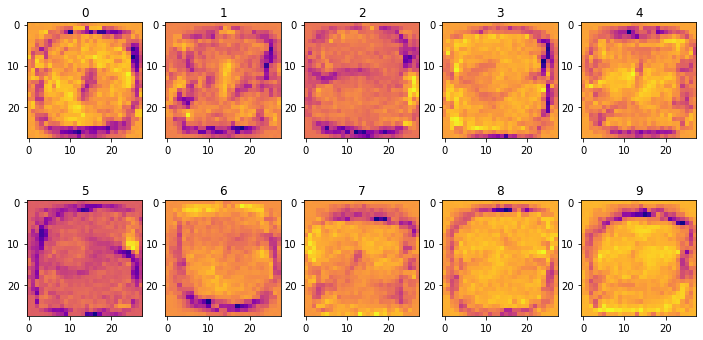

In [18]:
plt.figure(figsize=(12, 6))
with torch.no_grad():
    for i in range(10):
        weights = model.linear.weight[i].reshape(28,28)
        plt.subplot(2, 5, i+1)
        plt.imshow(weights.detach().numpy(), cmap='plasma')
        plt.title(str(i))

# Create larger network and train on GPU

In [35]:
class WideNet(nn.Module):
    """2 fully connected hidden layers."""
    def __init__(self, n_in, width, n_out):
        super(WideNet, self).__init__()
        self.fc1 = nn.Linear(n_in, width, bias=True)
        self.fc2 = nn.Linear(width, width, bias=True)
        self.fc3 = nn.Linear(width, n_out, bias=True)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [66]:
net = WideNet(28*28, 3000, 10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [67]:
for epoch in range(10):
    for batch in training_loader:
        x, labels = batch
        x = x.to(device)
        labels = labels.to(device)
        output = net(x)
        l = loss(output, labels)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            x, labels = batch
            x = x.to(device)
            labels = labels.to(device)
            output = net(x)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
    print(" Epoch {} | Accuracy = {:.4f}%".format(epoch, correct / len(test)))

 Epoch 0 | Accuracy = 0.9501%
 Epoch 1 | Accuracy = 0.9696%
 Epoch 2 | Accuracy = 0.9671%
 Epoch 3 | Accuracy = 0.9684%
 Epoch 4 | Accuracy = 0.9753%
 Epoch 5 | Accuracy = 0.9656%
 Epoch 6 | Accuracy = 0.9712%
 Epoch 7 | Accuracy = 0.9759%
 Epoch 8 | Accuracy = 0.9755%
 Epoch 9 | Accuracy = 0.9733%
